In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
data_path = "./dane/"
df = pd.read_csv(os.path.join(data_path, "dane_spr1.csv"), sep=';')

In [3]:
# macierz wartości poszczególnych ruchów. Im mniejsza wartosć tym lepiej.
Z = np.zeros(shape=(len(df), len(df)))
# lista zabronionych ruchów
tabu = pd.DataFrame(columns=["idx", "status"], dtype=np.int8)
# wartość optymalizacji po poszczególnym ruchu
optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])

In [4]:
# wypełnianie macierzy Z największymi możliwymi wartosciami poniżej głównej przekątnej
for i in range(len(Z)):
    for j in range(i):
        idx = (i, j)
        Z[idx] = np.inf

In [5]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
def get_KR(df = df):
    c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
    KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
    return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# generowanie tablicy możliwych ruchów 
def gen_Z(KR_before, df = df):
    global Z
    for i in range(len(df)):
        for j in range(i,len(df)):
            idx = (i, j)
            # sprawdzenie czy ruch nie jest zabroniony
            if check_in_tabu(idx):
                Z[idx] = np.inf
                continue
            swap(idx) # wykonanie pozornego ruchu
            Z[idx] = np.float64(get_KR() - KR_before) # obliczanie wpływu danego ruchu
            swap(idx) # powrót do stanu przed pozornym ruchem

def search_for_the_best_move(df = df):
    global Z
    # index najmniejszego elementu
    idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    return idx

def swap(idx, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx[0]], df.iloc[idx[1]] = df.iloc[idx[1]].copy(), df.iloc[idx[0]].copy()
    
def move(idx, inactive_time = 3, df=df):
    global tabu, optimalization
    swap(idx) # ruch
    # dodawanie wykonanego ruchu do listy zabronionych
    # inactive_time + 1 bo wstawiam ruch do tabu przed atkualizacją
    # w aktualizacji: (inactive_time + 1) - 1 -> inactive_time
    tabu = tabu.append({"idx": idx, "status": inactive_time + 1}, ignore_index=True)
    # aktualizacja listy zabronionych ruchów
    update_tabu()

# funkcja warunku, sprawdza czy ruch jest na liście zabronionych ruchów
def check_in_tabu(idx):
    global tabu
    for item in tabu.idx:
        if item == idx:
            return True
    return False
    
def update_tabu():
    global tabu
    tabu["status"] -= 1 # aktualizacja długości oczekiwania
    tabu = tabu[tabu["status"] != 0] # usuwanie ruchów które przestały być zabronione
    
def plot_optimalization(optimalization):
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")


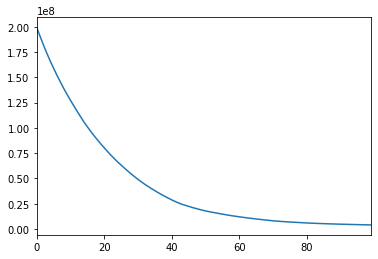

In [14]:
# wczytywanie wczesniej zoptymalizowanej tabeli ruchów i wartości optymalizacji
df = pd.read_csv(os.path.join(data_path, "zoptymalizowany_szereg.csv"), sep=';')
optimalization = pd.read_csv(os.path.join(data_path, "optymalizacja.csv"), sep=';')
plot_optimalization(optimalization)


In [13]:
def tabu_search_algorithm(inactive_time = 3, break_counter = 3, number_of_generations = 10):
    new_optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
    while number_of_generations and break_counter:
        print(f"{number_of_generations} iterations left.")
        KR_before = get_KR() # wartość KR przed wykonaniem ruchu
        gen_Z(KR_before) 
        best_move = search_for_the_best_move() # znajdz najlepszy ruch
        move(best_move, inactive_time) # wykonaj najlepszy ruch
        KR_now = get_KR() # wartość KR po wykonaniu ruchu

        # jeśli nowe ułożenie jest gorsze niż poprzednie
        if KR_before <= KR_now:
            break_counter -= 1 # jeśli zdarzy się tak 3 razy to przerywamy szukanie kombinacji
            continue # powtarzamy iteracje

        # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
        new_optimalization = new_optimalization.append({
            "Wartosc kombinacji": KR_now
        }, ignore_index=True)
        number_of_generations -= 1
    order = df["Zadanie"]
    
    return order, new_optimalization

In [8]:
# df.to_csv(os.path.join(data_path, "zoptymalizowany_szereg.csv"), sep=';', index_label=False)
# optimalization.to_csv(os.path.join(data_path, "optymalizacja.csv"), sep=';', index_label=False)

## Sprawdzanie różnych wartości parametrów
Zmieniamy parametry break_counter i inactive_time

In [11]:
new_order, new_opt = tabu_search_algorithm(inactive_time=10)

10 iterations left.
9 iterations left.
8 iterations left.
7 iterations left.
6 iterations left.
5 iterations left.
4 iterations left.
3 iterations left.
2 iterations left.
1 iterations left.


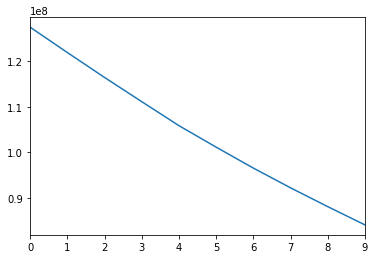

In [12]:
plot_optimalization(new_opt)

In [ ]:
ne